In [1]:
# !conda install -c conda-forge imbalanced-learn -y
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Reshape, Concatenate, Input
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Conv3D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
import psutil

import h5py
import gc

from sklearn.utils.class_weight import compute_class_weight

2024-01-19 09:45:15.407741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0
2.12.0


In [2]:
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

In [3]:


def load_combine_shuffle_data_optimized_hdf5():
    with h5py.File('/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/data.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for charge_type in ['positive-charge', 'negative-charge']:
            for data_type in ['sig', 'bkg']:
                # Construct dataset names
                input_dataset_name = f'{charge_type}_{data_type}_input'
                target_dataset_name = f'{charge_type}_{data_type}_target'

                # Check if the dataset exists and load data sequentially
                if input_dataset_name in h5f and target_dataset_name in h5f:
                    input_data = h5f[input_dataset_name][:].astype(np.float16)
                    target_data = h5f[target_dataset_name][:].astype(np.float16)

                    if combined_input is None:
                        combined_input = input_data
                        combined_target = target_data
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                    else:
                        print_memory_usage()
                        combined_input = np.vstack((combined_input, input_data))
                        combined_target = np.vstack((combined_target, target_data))
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                else:
                    print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

# Example usage
X, y = load_combine_shuffle_data_optimized_hdf5()


Total memory: 58.80 GB
Available memory: 40.92 GB
Used memory: 16.35 GB
Memory usage percentage: 30.4%
Total memory: 58.80 GB
Available memory: 39.79 GB
Used memory: 17.48 GB
Memory usage percentage: 32.3%
Total memory: 58.80 GB
Available memory: 38.67 GB
Used memory: 18.59 GB
Memory usage percentage: 34.2%


In [4]:
X = X.reshape(-1, 8*13*21)
scaler = StandardScaler()
standard_batch_size = 10000  # Adjust based on your system's capability
n = X.shape[0]
# Fit the scaler incrementally
for start in range(0, X.shape[0], standard_batch_size):
    end = start + standard_batch_size
    scaler.partial_fit(X[start:end, :])

# Transform the data in batches
scaled_X = np.empty_like(X, dtype=np.float16)
for start in range(0, X.shape[0], standard_batch_size):
    end = start + standard_batch_size
    scaled_X[start:end, :] = scaler.transform(X[start:end, :])

# Clean up
X = scaled_X
del scaled_X
gc.collect()

# X = X.reshape(-1, 8*13*21)
# print_memory_usage()
# X = StandardScaler().fit_transform(X)
# del X_reshaped
# gc.collect()
X = X.reshape(n,8,13,21)
print_memory_usage()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y
gc.collect()
print_memory_usage()
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
del X_temp
del y_temp
gc.collect()
print_memory_usage()

Total memory: 58.80 GB
Available memory: 38.54 GB
Used memory: 18.73 GB
Memory usage percentage: 34.5%
Total memory: 58.80 GB
Available memory: 38.55 GB
Used memory: 18.72 GB
Memory usage percentage: 34.4%
Total memory: 58.80 GB
Available memory: 38.55 GB
Used memory: 18.72 GB
Memory usage percentage: 34.4%


In [5]:
def to_sum(X, y):
    if X.shape[1:] == (8, 13, 21) and y.shape[1:] == (13, ):
        #y_expanded = np.repeat(y[:,7], 8, axis=0).reshape(-1, 8, 1)
        X_sum = np.sum(X, axis=3)
        X_sum.reshape(X_sum.shape[0],8,13,1)
        n = y.shape[0]
        one_hot = np.zeros((n, 3))

        # Class 1: np.abs(y[:, 8]) > 2
        one_hot[np.abs(y[:, 8]) >= 2, 0] = 1

        # Class 2: np.abs(y[:, 8]) <= 2 and y[:, 13] == 1
        one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] > 0), 1] = 1

        # Class 3: np.abs(y[:, 8]) <= 2 and y[:, 13] == -1
        one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] < 0), 2] = 1
        return X_sum, one_hot, y[:,7].reshape(-1, 1)
    else:
        raise ValueError("Wrong array shape!")


X_sum_train, y_sum_train, y0_train = to_sum(X_train, y_train)
X_sum_val, y_sum_val, y0_val = to_sum(X_val, y_val)
X_sum_test, y_sum_test, y0_test = to_sum(X_test, y_test)
del X_train
del y_train
del X_val
del y_val
del X_test
del y_test
gc.collect()
print_memory_usage()

Total memory: 58.80 GB
Available memory: 42.80 GB
Used memory: 14.47 GB
Memory usage percentage: 27.2%


In [6]:

def DNN():
    # Cluster y-profile input
    y_profile_input = Input(shape=(8, 13, 1))  # Adjust the shape based on your input
    flatten = Flatten()(y_profile_input)
    y0_input = Input(shape=(1,))
    concat = Concatenate()([flatten, y0_input])
    
    dense = Dense(128, activation='relu')(concat)
    dropout = Dropout(0.5)(dense)
    dense1 = Dense(64, activation='relu')(dropout)

    # Output layer (adjust based on your classification problem)
    output = Dense(3, activation='softmax')(dense1)  # Change number of neurons based on the number of classes

    model = Model(inputs=[y_profile_input, y0_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and summarize the model
model = DNN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 13, 1)]   0           []                               
                                                                                                  
 flatten (Flatten)              (None, 104)          0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 105)          0           ['flatten[0][0]',                
                                                                  'input_2[0][0]']            

2024-01-19 09:47:33.133401: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

In [8]:
checkpoint_path = "cp.ckpt"
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                   mode='max',
                                   patience=20,
                                   restore_best_weights=False)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)
csv_logger = CSVLogger('log.csv', append=False, separator=';')

In [9]:

class_labels = np.argmax(y_sum_train, axis=1)

# Now use class_labels to compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [10]:

model = DNN()

# Define training parameters
epochs = 200  # Number of epochs to train
batch_size = 1024  # Number of samples per gradient update

# Train the model
history = model.fit(
    [X_sum_train, y0_train], y_sum_train,  # Training data and labels
    validation_data=([X_sum_val, y0_val], y_sum_val),  # Validation data
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[earlyStop_callback]
)

Epoch 1/200
860/860 [==============================] - 15s 17ms/step - loss: 1.1087 - accuracy: 0.4840 - val_loss: 1.0277 - val_accuracy: 0.4998
Epoch 2/200
860/860 [==============================] - 19s 22ms/step - loss: 1.0287 - accuracy: 0.4986 - val_loss: 1.0121 - val_accuracy: 0.5010
Epoch 3/200
860/860 [==============================] - 7s 8ms/step - loss: 1.0149 - accuracy: 0.5026 - val_loss: 0.9944 - val_accuracy: 0.5108
Epoch 4/200
860/860 [==============================] - 13s 15ms/step - loss: 0.9998 - accuracy: 0.5106 - val_loss: 0.9760 - val_accuracy: 0.5263
Epoch 5/200
860/860 [==============================] - 14s 17ms/step - loss: 0.9867 - accuracy: 0.5191 - val_loss: 0.9606 - val_accuracy: 0.5330
Epoch 6/200
860/860 [==============================] - 16s 19ms/step - loss: 0.9766 - accuracy: 0.5263 - val_loss: 0.9457 - val_accuracy: 0.5462
Epoch 7/200
860/860 [==============================] - 16s 18ms/step - loss: 0.9676 - accuracy: 0.5325 - val_loss: 0.9392 - val_accu

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

3437/3437 [==============================] - 4s 1ms/step


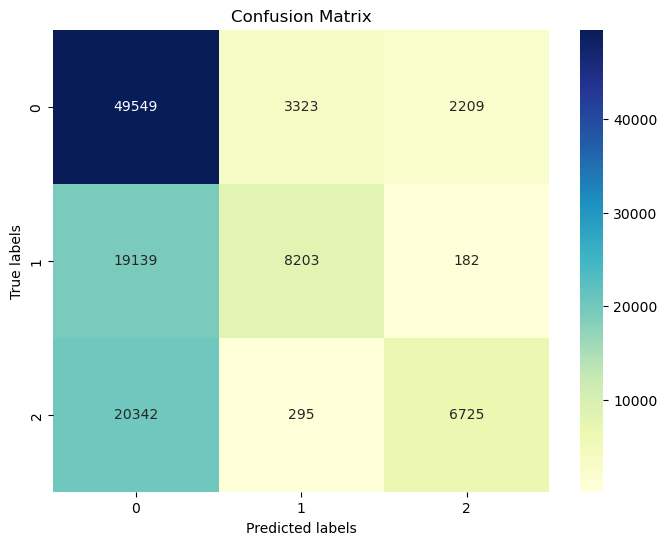

In [12]:
from sklearn.metrics import confusion_matrix
predictions_prob = model.predict([X_sum_test, y0_test])
predictions_labels = np.argmax(predictions_prob, axis=1)
y_test_labels = np.argmax(y_sum_test, axis=1)
cm = confusion_matrix(y_test_labels, predictions_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Signal Efficiency
signal_efficiency = cm[0, 0] / np.sum(cm[0, :])

# Background Rejection Rate
background_rejection = (cm[1, 1] + cm[1, 2]+cm[2, 1] + cm[2, 2]) / (np.sum(cm[1, :]) + np.sum(cm[2, :]))

print("Signal Efficiency:", signal_efficiency)
print("Background Rejection Rate:", background_rejection)

Signal Efficiency: 0.8995660935712859
Background Rejection Rate: 0.2806726669824728


In [14]:
from sklearn.metrics import roc_auc_score
class_1_true = y_sum_test[:, 0]
class_1_scores = predictions_prob[:, 0]

# Calculate the AUC for class 1
class_1_auc = roc_auc_score(class_1_true, class_1_scores)

print("Class 1 AUC:", class_1_auc)

Class 1 AUC: 0.6279232257513405


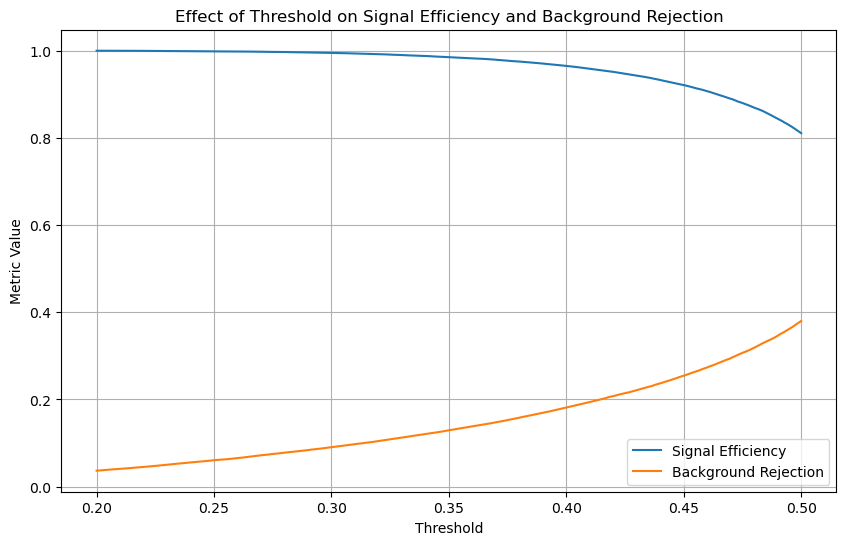

In [15]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.2, 0.5, 500)
signal_efficiencies = []
background_rejections = []

for threshold in thresholds:
    # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
    predicted_class = (predictions_prob[:, 0] > threshold).astype(int)
    # Compute confusion matrix
    cm = confusion_matrix(y_sum_test[:, 0], predicted_class)
    
    # Calculate signal efficiency and background rejection
    signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
    background_rejection = cm[0, 0] / np.sum(cm[0, :])
    
    # Store metrics
    signal_efficiencies.append(signal_efficiency)
    background_rejections.append(background_rejection)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency')
plt.plot(thresholds, background_rejections, label='Background Rejection')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Effect of Threshold on Signal Efficiency and Background Rejection')
plt.legend()
plt.grid(True)
plt.show()

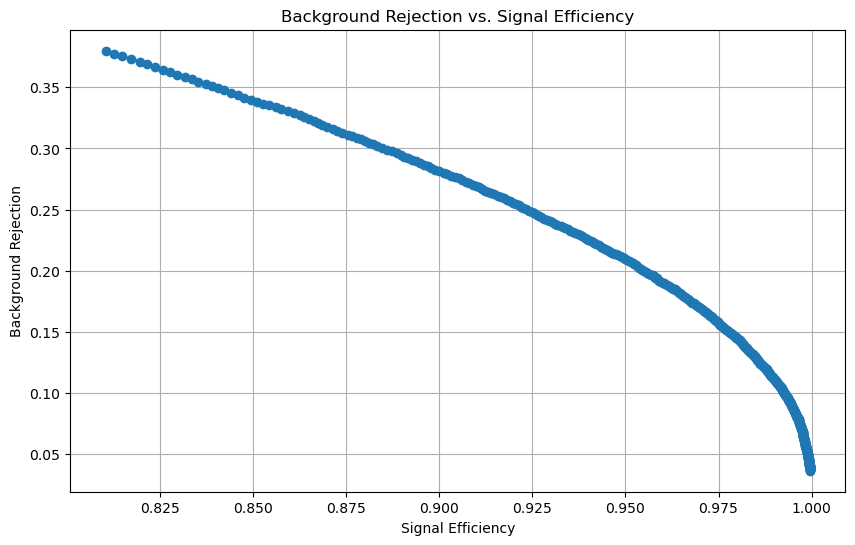

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(signal_efficiencies, background_rejections, marker='o')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Background Rejection vs. Signal Efficiency')
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_sum_test, predictions_prob)
print(f"AUC: {auc}")

AUC: 0.7220191865065276


In [18]:
def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)

    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)

    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)

    return closest_index


index_848 = find_closest(signal_efficiencies, 0.848)
index_933 = find_closest(signal_efficiencies, 0.933)
index_976 = find_closest(signal_efficiencies, 0.976)
print(f"Signal Efficiency:{signal_efficiencies[index_848]*100:.1f}%",f"Background Rejections:{background_rejections[index_848]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_933]*100:.1f}%",f"Background Rejections:{background_rejections[index_933]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_976]*100:.1f}%",f"Background Rejections:{background_rejections[index_976]*100:.1f}%")

Signal Efficiency:84.8% Background Rejections:34.1%
Signal Efficiency:93.3% Background Rejections:23.6%
Signal Efficiency:97.6% Background Rejections:15.5%


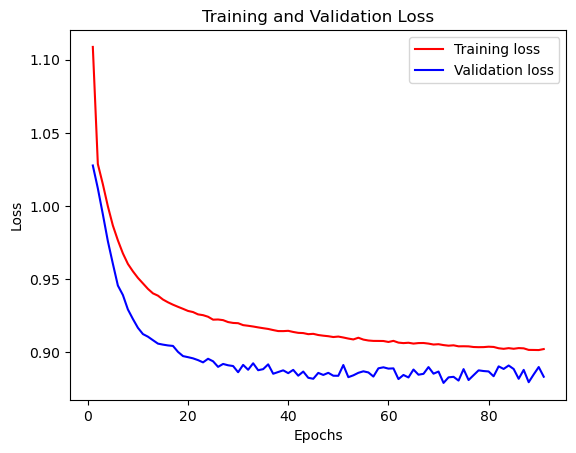

In [19]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

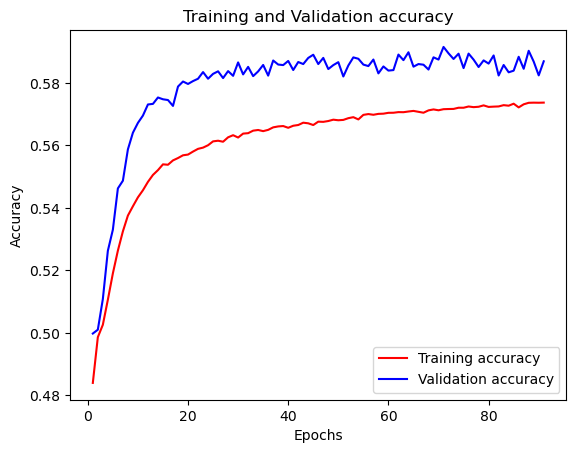

In [20]:
epochs = range(1, len(train_accuracy) + 1)
plt.figure()
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
print(np.sum(y_sum_train[:,0]))
print(y_sum_train.shape)
print(np.sum(y_sum_test[:,0]))
print(y_sum_test.shape)

439800.0
(879734, 3)
55081.0
(109967, 3)


In [22]:
print(train_accuracy, val_accuracy)

[0.4840122163295746, 0.4986473321914673, 0.5026133060455322, 0.5106213688850403, 0.5190534591674805, 0.5263329744338989, 0.5325064063072205, 0.5375556945800781, 0.5405349731445312, 0.5433903932571411, 0.5456581115722656, 0.5483396053314209, 0.5505653023719788, 0.5520998239517212, 0.553949236869812, 0.553824245929718, 0.5552144050598145, 0.5559680461883545, 0.5568490028381348, 0.5570785999298096, 0.558039128780365, 0.5589087009429932, 0.5593008995056152, 0.5600669980049133, 0.5613037347793579, 0.5615083575248718, 0.561186671257019, 0.5626018643379211, 0.5632770657539368, 0.5625314116477966, 0.563785195350647, 0.5639261603355408, 0.5647309422492981, 0.5649446249008179, 0.5645751953125, 0.5649867057800293, 0.5657857656478882, 0.5660824775695801, 0.5662029385566711, 0.5656482577323914, 0.5663007497787476, 0.5665382742881775, 0.5672793984413147, 0.5670804977416992, 0.5665292143821716, 0.5676090717315674, 0.5675499439239502, 0.5678114295005798, 0.5682421922683716, 0.5680569410324097, 0.56817

In [23]:
# model.save('DNNw_time.h5')
# Dense_w4 = model.layers[4].get_weights()[0].flatten(order='C')
# Dense_b4 = model.layers[4].get_weights()[1].flatten(order='C')

# Dense_w6 = model.layers[6].get_weights()[0].flatten(order='C')
# Dense_b6 = model.layers[6].get_weights()[1].flatten(order='C')

# Dense_w7 = model.layers[7].get_weights()[0].flatten(order='C')
# Dense_b7 = model.layers[7].get_weights()[1].flatten(order='C')

In [24]:
# np.savetxt('DNN_Dense_w4_1024.txt', Dense_w4)
# np.savetxt('DNN_Dense_b4_1024.txt', Dense_b4)

# np.savetxt('DNN_Dense_w6_256.txt', Dense_w6)
# np.savetxt('DNN_Dense_b6_256.txt', Dense_b6)

# np.savetxt('DNN_Dense_w7_3.txt', Dense_w7)
# np.savetxt('DNN_Dense_b7_3.txt', Dense_b7)